# Higgs Boson Analysis with CMS Open Data
This is an example analysis of the Higgs boson detection via the decay channel H &rarr; ZZ* &rarr; 4l  
From the decay products measured at the CMS experiment and provided as open data, you will be able to produce a histogram, and from there you can infer the invariant mass of the Higgs boson.  
Code: it is based on the original work on [cms opendata notebooks](https://github.com/cms-opendata-analyses/HiggsExample20112012) and this [notebook with RDataFrame implementation](https://root.cern/doc/master/df103__NanoAODHiggsAnalysis_8py.html)  
Reference: link to the [original article with CMS Higgs boson discovery](https://inspirehep.net/record/1124338)

See also: https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

Author and contact: Luca.Canali@cern.ch  
April, 2022

In [ ]:
# Run this if you need to install Apache Spark (PySpark)

# !pip install pyspark

# Install sparkhistogram
# Note: if you cannot install the package, create the computeHistogram
# function as detailed at the end of this notebook.

!pip install sparkhistogram

In [ ]:
# Run this to download the dataset 
# See further details at https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

!wget https://sparkdltrigger.web.cern.ch/sparkdltrigger/CMS_Higgs_opendata/SMHiggsToZZTo4L.parquet


## H &rarr; ZZ* &rarr; 4$\mu$ - cuts and plot, using Monte Carlo signal data
### (this is a step of the broader analsys)

In [2]:
# Start the Spark Session
# This uses local mode for simplicity

# the use of findspark is optional
# import findspark
# findspark.init("/home/luca/Spark/spark-3.5.1-bin-hadoop3")

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("H_ZZ_4Lep")
         .master("local[*]")
         .config("spark.driver.memory", "8g")
         .getOrCreate()
        )

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/07 23:01:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read data with the candidate events
# Only Muon events for this reduced-scope notebook

path = "./"

df_MC_events_signal = spark.read.parquet(path + "SMHiggsToZZTo4L.parquet")

df_MC_events_signal.printSchema()


root
 |-- run: integer (nullable = true)
 |-- luminosityBlock: long (nullable = true)
 |-- event: decimal(20,0) (nullable = true)
 |-- PV_npvs: integer (nullable = true)
 |-- PV_x: float (nullable = true)
 |-- PV_y: float (nullable = true)
 |-- PV_z: float (nullable = true)
 |-- nMuon: long (nullable = true)
 |-- Muon_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_mass: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- Muon_pfRelIso03_all: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_pfRelIso04_all: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_tightId: array (nullable = true)
 |    |-- element:

In [4]:
# Count the number of events before cuts (filter)

print(f"Number of events, MC signal: {df_MC_events_signal.count()}")

Number of events, MC signal: 299973


### Apply  cuts
More details on the cuts (filters applied to the event data) in the reference CMS paper on the [discovery of the Higgs boson](https://arxiv.org/pdf/1207.7235.pdf)

In [5]:
df_events = df_MC_events_signal.selectExpr("""arrays_zip(Muon_charge, Muon_mass, Muon_pt, Muon_phi, Muon_eta, 
                                      Muon_dxy, Muon_dz, Muon_dxyErr, Muon_dzErr, Muon_pfRelIso04_all) Muon""",
                                 "nMuon")

In [6]:
df_events.printSchema()

root
 |-- Muon: array (nullable = true)
 |    |-- element: struct (containsNull = false)
 |    |    |-- Muon_charge: integer (nullable = true)
 |    |    |-- Muon_mass: float (nullable = true)
 |    |    |-- Muon_pt: float (nullable = true)
 |    |    |-- Muon_phi: float (nullable = true)
 |    |    |-- Muon_eta: float (nullable = true)
 |    |    |-- Muon_dxy: float (nullable = true)
 |    |    |-- Muon_dz: float (nullable = true)
 |    |    |-- Muon_dxyErr: float (nullable = true)
 |    |    |-- Muon_dzErr: float (nullable = true)
 |    |    |-- Muon_pfRelIso04_all: float (nullable = true)
 |-- nMuon: long (nullable = true)



In [7]:
# Apply filters to the input data

# Keep only events with at least 4 muons
df_events = df_events.filter("nMuon >= 4")


In [8]:
# Filter Muon arrays
# Filters are detailed in the CMS Higgs bosono paper
# See notebook with RDataFrame implementation at https://root.cern/doc/master/df103__NanoAODHiggsAnalysis_8py.html
# Article: with CMS Higgs boson discovery](https://inspirehep.net/record/1124338

df_events_filtered = df_events.selectExpr("""filter(Muon, m ->
                        abs(m.Muon_pfRelIso04_all) < 0.40  -- Require good isolation
                        and m.Muon_pt > 5                  -- Good muon kinematics
                        and abs(m.Muon_eta) < 2.4        
                        -- Track close to primary vertex with small uncertainty
                        and (m.Muon_dxy * m.Muon_dxy + m.Muon_dz * m.Muon_dz) / (m.Muon_dxyErr * m.Muon_dxyErr + m.Muon_dzErr*m.Muon_dzErr) < 16
                        and abs(m.Muon_dxy) < 0.5
                        and abs(m.Muon_dz) < 1.0
                     ) as Muon""")


In [9]:
# only events with exactly 4 Muons left after the previous cuts
df_events_filtered = df_events_filtered.filter("size(Muon) == 4")
    
# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
df_events_4muons = df_events_filtered.filter("Muon.Muon_charge[0] + Muon.Muon_charge[1] + Muon.Muon_charge[2] + Muon.Muon_charge[3] == 0")

print(f"Number of events after applying cuts: {df_events_4muons.count()}")

Number of events after applying cuts: 12279


### Compute the invariant mass
This computes the 4-vectors sum for the 4-lepton system
using formulas from special relativity.  
See also http://edu.itp.phys.ethz.ch/hs10/ppp1/2010_11_02.pdf
and https://en.wikipedia.org/wiki/Invariant_mass

In [10]:
# This computes the 4-vectors sum for the 4-muon system

# convert to cartesian coordinates
df_4lep = df_events_4muons.selectExpr(
"Muon.Muon_pt[0] * cos(Muon.Muon_phi[0]) P0x", "Muon.Muon_pt[1] * cos(Muon.Muon_phi[1]) P1x", "Muon.Muon_pt[2] * cos(Muon.Muon_phi[2]) P2x", "Muon.Muon_pt[3] * cos(Muon.Muon_phi[3]) P3x",
"Muon.Muon_pt[0] * sin(Muon.Muon_phi[0]) P0y", "Muon.Muon_pt[1] * sin(Muon.Muon_phi[1]) P1y", "Muon.Muon_pt[2] * sin(Muon.Muon_phi[2]) P2y", "Muon.Muon_pt[3] * sin(Muon.Muon_phi[3]) P3y",
"Muon.Muon_pt[0] * sinh(Muon.Muon_eta[0]) P0z", "Muon.Muon_pt[1] * sinh(Muon.Muon_eta[1]) P1z", "Muon.Muon_pt[2] * sinh(Muon.Muon_eta[2]) P2z", "Muon.Muon_pt[3] * sinh(Muon.Muon_eta[3]) P3z",
"Muon.Muon_mass[0] as Mass"
)


# compute energy for each muon
df_4lep = df_4lep.selectExpr(
 "P0x", "P0y", "P0z", "sqrt(Mass* Mass + P0x*P0x + P0y*P0y + P0z*P0z) as E0",
 "P1x", "P1y", "P1z", "sqrt(Mass* Mass + P1x*P1x + P1y*P1y + P1z*P1z) as E1",
 "P2x", "P2y", "P2z", "sqrt(Mass* Mass + P2x*P2x + P2y*P2y + P2z*P2z) as E2",
 "P3x", "P3y", "P3z", "sqrt(Mass* Mass + P3x*P3x + P3y*P3y + P3z*P3z) as E3"
)

# sum energy and momenta over the 4 muons
df_4lep = df_4lep.selectExpr(
 "P0x + P1x + P2x + P3x as Px",
 "P0y + P1y + P2y + P3y as Py",
 "P0z + P1z + P2z + P3z as Pz",
 "E0 + E1 + E2 + E3 as E"
)

df_4lep.show(5)

+-------------------+-------------------+------------------+------------------+
|                 Px|                 Py|                Pz|                 E|
+-------------------+-------------------+------------------+------------------+
|  5.311811653121633|  9.915075035642875|-46.46428849338781|119.68020418511728|
| 22.661705611756854| 13.587090233397214|-76.61472199308764|147.16164198962448|
|-27.517601024367103|  -95.9115300600873| 64.09032110424545|171.83558355242639|
|-31.820404279871955|  6.468262098449042|-246.5480258533116| 278.6100202584995|
|-23.896063904693264|-40.377128320338514|131.70634333785046|  186.063294788725|
+-------------------+-------------------+------------------+------------------+
only showing top 5 rows



In [11]:
# This computes the invariant mass for the 4-muon system

df_4lep_invmass = df_4lep.selectExpr("sqrt(E * E - ( Px * Px + Py * Py + Pz * Pz)) as invmass_GeV")

df_4lep_invmass.show(5)

+------------------+
|       invmass_GeV|
+------------------+
| 109.7173510097374|
|122.83554585200446|
|124.35295955848554|
|125.63135672740138|
| 122.7666666105827|
+------------------+
only showing top 5 rows



In [12]:
# This defines the DataFrame transformation to compute the histogram of the invariant mass
# The result is a histogram with (energy) bin values and event counts foreach bin

# Requires sparkhistogram
# See https://github.com/LucaCanali/Miscellaneous/blob/master/Spark_Notes/Spark_DataFrame_Histograms.md 
from sparkhistogram import computeHistogram

# histogram parameters
min_val = 80
max_val = 250
step = 3.0
num_bins = (max_val - min_val) / step

# use the helper function computeHistogram in the package sparkhistogram
histogram_data = computeHistogram(df_4lep_invmass, "invmass_GeV", min_val, max_val, num_bins) 


In [13]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()


24/05/07 23:01:44 WARN DAGScheduler: Broadcasting large task binary with size 1727.6 KiB


CPU times: user 320 ms, sys: 41.4 ms, total: 361 ms
Wall time: 5.32 s


24/05/07 23:01:45 WARN DAGScheduler: Broadcasting large task binary with size 1735.3 KiB


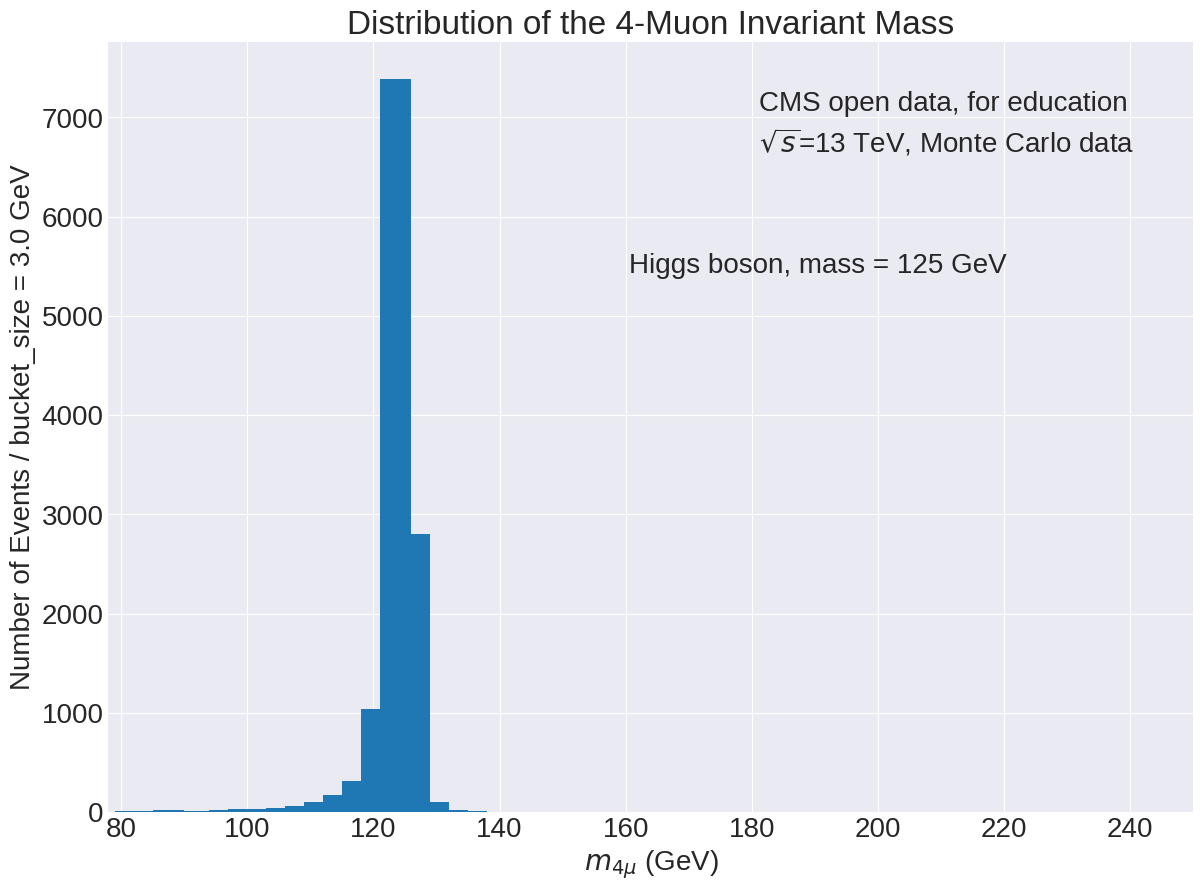

In [14]:
# This plots the data histogram with error bars

import matplotlib.pyplot as plt 

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

x = histogram_data_pandas["value"]
y = histogram_data_pandas["count"]

# scatter plot
#ax.plot(x, y, marker='o', color='red', linewidth=0)
#ax.errorbar(x, y, err, fmt = 'ro')
# histogram with error bars
ax.bar(x, y, width = 5.0, capsize = 5, linewidth = 0.5, ecolor='blue', fill=True)

ax.set_xlim(min_val-2, max_val)

ax.set_xlabel("$m_{4\mu}$ (GeV)")
ax.set_ylabel(f"Number of Events / bucket_size = {step} GeV")
ax.set_title("Distribution of the 4-Muon Invariant Mass")

# Label for the Z ang Higgs spectrum peaks
txt_opts = {'horizontalalignment': 'left',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.text(0.48, 0.71, "Higgs boson, mass = 125 GeV", **txt_opts)

# Add energy and luminosity
plt.text(0.60, 0.92, "CMS open data, for education", **txt_opts)
plt.text(0.60, 0.87, '$\sqrt{s}$=13 TeV, Monte Carlo data', **txt_opts)

plt.show()

In [14]:
spark.stop()

## Note on sparkhistogram

Use this to define the computeHistogram function if you cannot pip install sparkhistogram

In [ ]:
def computeHistogram(df: "DataFrame", value_col: str, min_val: float, max_val: float, bins: int) -> "DataFrame":
    """ This is a dataframe function to compute the count/frequecy histogram of a column
        
        Parameters
        ----------
        df: the dataframe with the data to compute
        value_col: column name on which to compute the histogram
        min: minimum value in the histogram
        max: maximum value in the histogram
        bins: number of histogram buckets to compute
        
        Output DataFrame
        ----------------
        bucket: the bucket number, range from 1 to bins (included)
        value: midpoint value of the given bucket
        count: number of values in the bucket        
    """
    # Compute the step size for the histogram
    step = (max_val - min_val) / bins

    # Get the Spark Session handle
    spark = SparkSession.getActiveSession()

    # df_buckets is the range of {bins} buckets as requested by the user
    # It will be used to fill in for missing buckets, i.e. buckets with no corresponding values
    df_buckets = spark.range(bins).selectExpr("id + 1 as bucket")

    # Group user data into buckets and count their population count
    df_grouped = (df
                   .selectExpr(f"width_bucket({value_col}, {min_val}, {max_val}, {bins}) as bucket")
                   .groupBy("bucket")
                   .count()
                 )

    # join df_buckets with the grouped data to fill in missing buckets
    df_hist = (df_buckets # note this will be typically broadcasted, the order of the join is important
               .join(df_grouped, "bucket", "left_outer") # add missing buckets and remove buckets out of range
               .selectExpr("bucket", f"{min_val} + (bucket - 0.5) * {step} as value",  # use center value of the buckets
                           "nvl(count, 0) as count") # buckets with no values will have a count of 0
               .orderBy("bucket")
              )

    return df_hist